My ultimate goal is to build a neural network to predict lung cancer diagnosis using the set over 1000 chest CT scans and associated diagnosis data provided in the Data Science Bowl 2017.  As pre-processing steps in my analysis I need to load the DICOM files, convert the pixel values in the images to Hounsfield Units (HU, a measure of radiodensity), derive the slice thickness of each image, and resize the images so that each voxel represents 1 mm^3 in real space. After those preprocessing steps, I will be able to use multiple slices from individual patients' scans to disply a 3D image of their lung. Big thanks to Guido Zuidhof (https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial/notebook) for his tutorial, which this code is based on..

In [55]:
%matplotlib inline

import numpy as np 
import pandas as pd
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt 
import time

from multiprocessing import Pool, cpu_count
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from functools import partial

# Some constants 
INPUT_FOLDER = 'DataScienceBowl2017_Data/stage2/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()
print(patients[1:15])

['007c1246c5fe6f200378f6b91323dc2a', '00f6c1bd02eb49e3d8dbfc7d957a709e', '0171e54e4c0f68e8fc8c24523f71a86f', '019cb268efb93de5446984242bac0380', '01cb8771b8da81fc4a7cc48595832523', '0214c2ae7a8a922099f60f1f7f1b0027', '0253545cc6415a055faad7192f31a1ca', '02aad899c461807ade5bde2ed3e61c09', '030d5e1a5dbe0600320ceb2a9ee35b13', '03990e71d5a98502e4e7f63f8203d760', '04f10322dd24edfaa7283e32b9bd6b30', '0504cf4053de140cf882df042ce79372', '05e708a2a57caa99a3caf0327cbc5382', '060e549637d08dd67050b0f27d56ba0b']


In [3]:
# This function will load the scan for a given patient and infer the slice thickness for each scan
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [4]:
# This function will convert pixels to Hounsfield Units
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices]) #make 3D arrays combining all slices for each patient 
    image = image.astype(np.int16) #convert to int16

    # Pixels that were outside the scanning bounds have been set to -2000
    # Reset to have HU of air = 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept #RescaleIntercept included in metadata of pic
        slope = slices[slice_number].RescaleSlope #RescaleIntercept included in metadata of pic
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

Let's use these two functions to do some basic exploration of what data we have here. For this proof of concept EDA, I will be working with a subset of the patients. Here's the number of patients I will be working with, and how many slices each there are for each patient.

In [19]:
print("There are scans from " + str(len(patients)) + " patients in this subset of the data.")
scan_lens = []
for patient in patients:
    scan = load_scan(INPUT_FOLDER + patient)
    scan_lens.append(len(scan))
print(str(np.median(scan_lens)) + "= median value of scan lengths")

There are scans from 506 patients in this subset of the data.
360.0= median value of scan lengths


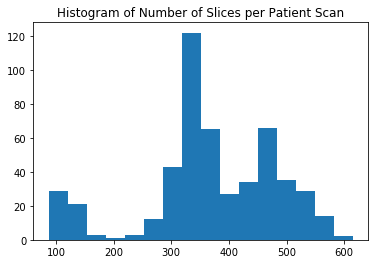

In [21]:
#display number of slices per patient scan in histogram
plt.hist(scan_lens, bins='auto')
plt.title("Histogram of Number of Slices per Patient Scan")
plt.show()

We need to resize all the images so that for every image, 1 voxel corresponds to approximately 1 mm^3 of lung. This will give the images "isomorphic resolution," which will allow us to train a convoluted neural network on them down the line.

In [44]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)
    #print("spacing: ", spacing)

    resize_factor = spacing / new_spacing
    #print("resize_factor: ", resize_factor)
    new_real_shape = image.shape * resize_factor
    #print("new_real_shape: ", new_real_shape)
    new_shape = np.round(new_real_shape)
    #print("new_shape: ", new_shape)
    real_resize_factor = new_shape / image.shape
    #print("real_resize_factor: ", real_resize_factor)
    new_spacing = spacing / real_resize_factor
    #print("new_spacing: ", new_spacing)
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

Let's read in the scan for the first patient, resize it, and see how the shape of our image array changes when we do so. You'll see the shape of the image after resizing is much closer to an approximate 1:1:1.

In [12]:
# read scan from first patient
first_patient = load_scan(INPUT_FOLDER + patients[0])
first_patient_hu = get_pixels_hu(first_patient)

# resize the scan
first_patient_resampled, spacing = resample(first_patient_hu, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_hu.shape)
print("Shape after resampling\t", first_patient_resampled.shape)

spacing:  [ 0.625       0.72070301  0.72070301]
resize_factor:  [ 0.625       0.72070301  0.72070301]
new_real_shape:  [ 298.75        368.99993896  368.99993896]
new_shape:  [ 299.  369.  369.]
real_resize_factor:  [ 0.62552301  0.72070312  0.72070312]
new_spacing:  [ 0.99916388  0.99999983  0.99999983]
Shape before resampling	 (478, 512, 512)
Shape after resampling	 (299, 369, 369)


In [21]:
np.asarray([478, 512, 512]) * np.asarray([0.625, 0.72070301, 0.72070301])/(np.asarray([1,1,1]))

array([ 764.8       ,  710.41745753,  710.41745753])

In [30]:
print(first_patient[0].SliceThickness)
print(first_patient[0].PixelSpacing)
print(np.array([first_patient[0].SliceThickness] + first_patient[0].PixelSpacing, dtype=np.float32))

0.625
['0.720703', '0.720703']
[ 0.625       0.72070301  0.72070301]


It would be neat to visualize these scans in 3D. Following Zuidhof's tutorial, I will use the marching cubes method from the skimage package. The function plot_3d defined below takes an image (as a 3D array) and displays those parts of the image whose radiodensity in HU is above a certain threshold. This allows the user to choose which kinds of tissues to display in the visualization.

In [30]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces, _ , _ = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # `verts[faces]` generates a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

We can now visualize a patients scan in 3D. Let's do this for the first patient. We can use a threshold to limit the tissue type that we plot. We will use a threshold of 400 HU to limit the scan to displaying bone. 

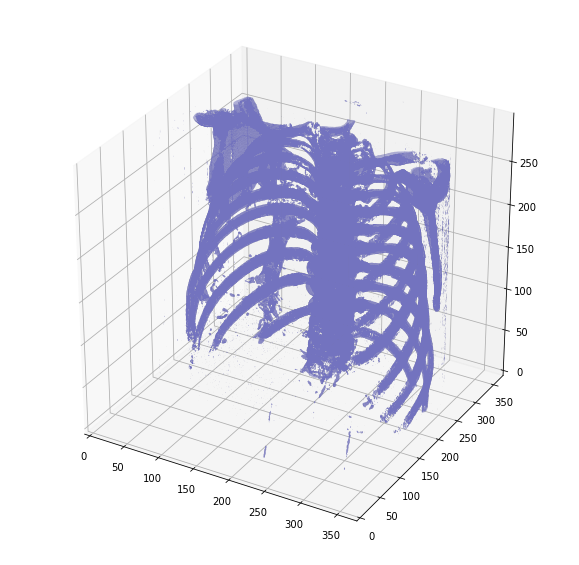

In [31]:
plot_3d(first_patient_resampled, 400)

If we up the HU threshold to 700, we limit the image to yet denser portions of the chest.

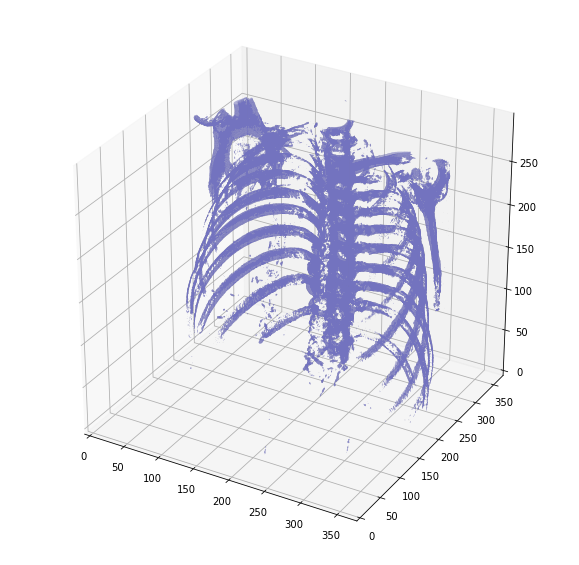

In [32]:
plot_3d(first_patient_resampled, 700)

We'll wrap these steps up into one function that is called per patient:

In [38]:
def preprocess_and_save_scan(patient, data_dir, prep_folder, use_existing = True):
    
    if not os.path.exists(prep_folder):
        os.mkdir(prep_folder)
    
    if use_existing:
        if os.path.exists(os.path.join(prep_folder,patient+'_clean.npy')):
            print(patient+' had been done')
            return
        
    try:
        slices = load_scan(data_dir + patient)
        patient_hu = get_pixels_hu(slices)
        patient_resampled, spacing = resample(patient_hu, slices, [1,1,1])
        np.save(os.path.join(prep_folder,patient+'_clean'),patient_resampled)
        
    except:
        print('bug in '+patient)
        raise
    print(patient+' done')

Try to preprocess and save one patient's scan:

In [45]:
preprocess_and_save_scan(patient = patients[0], data_dir = INPUT_FOLDER, prep_folder = 'DataScienceBowl2017_Data/stage2_clean/', use_existing = True)

004828796b994741c4466f59a8c7e9a4 had been done


In [43]:
#reload this file we just saved - walla! there it is, ready to be used.
test = np.load('DataScienceBowl2017_Data/stage2_clean/004828796b994741c4466f59a8c7e9a4_clean.npy')
test.shape
test[0][:5, :5]

array([[-2048, -2048, -2048, -2048, -2048],
       [-2048, -2048, -2048, -2048, -2048],
       [-2048, -2048, -2048, -2048, -2048],
       [-2048, -2048, -2048, -2048, -2048],
       [-2048, -2048, -2048, -2048, -2048]], dtype=int16)

## Preprocessing a whole batch of data in parallel

I'm now going to run the conversion to Hounsfield + resampling code on all the images in the stage2 data directory (scans from 506 patients, 98 GB of data)

In [49]:
cpu_count()

8

In [52]:
def batch_preprocess_and_save(data_dir,prep_folder,n_worker = None,use_existing=True):
      
    print('starting preprocessing')
    pool = Pool(n_worker)
    patients = [f for f in os.listdir(data_dir)]
    partial_prepandsave = partial(preprocess_and_save_scan, data_dir = data_dir, prep_folder = prep_folder, use_existing = use_existing)

    #N = len(filelist)
    _=pool.map(partial_prepandsave,patients)
    pool.close()
    pool.join()
    print('end preprocessing')
    #return filelist

In [ ]:
start = time.time()
batch_preprocess_and_save(data_dir=INPUT_FOLDER, prep_folder='DataScienceBowl2017_Data/stage2_clean/', n_worker=8, use_existing=True)
end = time.time()
print(end - start)

starting preprocessing
004828796b994741c4466f59a8c7e9a4 had been done
1695fee1f1dcac0094ddcd0c4a5d78a5 done
06a54f06a8eba76e85bb38e167fbc353 done
2805ecbf568656eff77e968f27f55711 done
007c1246c5fe6f200378f6b91323dc2a done
368a29bb6c317958e06c1b6cfdc4a3a1 done
315ca8a98de38b056e9432cff8896d4e done
0eb838fa78eeca9c4b67ea4d0d37a82f done
28b6f19fbb5c6508faace72f8c82a5f4 done
1eac4619a61c1bd6ad95880574cdb896 done
3171f8f427b1879c859dd0aac9c8a684 done
0f5066ad16052f57aceebe9bfc248595 done
071d08f7b19faf23606440d69d387b70 done
172f016737a31607818a98360f25a0d6 done
00f6c1bd02eb49e3d8dbfc7d957a709e done
36d352f118d3560d7f3bc100e26fe3fe done
0171e54e4c0f68e8fc8c24523f71a86f done
370f849df7e2b4570548158dfc63a90c done
2929c9d58614c92b0e658e2dd5503225 done
0f704d66a922144905e4318d7cf45aa0 done
31ac446f60a24d2fa8f536e2f37ce8b1 done
19df071f31180ed0e0620a5f914abf7a done
07625e01a28581f0d854cd53f9fd46ee done
1ec3740d37c058058bf70949ba9e5766 done
019cb268efb93de5446984242bac0380 done
375d9053901012538e

60cdc2a04b344c7d1321c8e8c50897f4 had been done
60f3a7a872f76dcde1ef5560ffd447d0 had been done
6202d9530fc2c8619575af4ab1509ba6 had been done
6202db4b61c151e3e1d86cf5d3a75877 had been done
630942a485dfbf5fab1a902dcfbe450c had been done
63248fdafd2df302b57a479289d76105 had been done
63c86a1b73e2192b9785ff04d384d1bc had been done
64234780b8febcc6b0971d7f0a2d58f8 had been done
6451cbfc34c329168a1ecc5a103344fa had been done
647b7661f3f5178e7fdd132b6c287ecb had been done
65bbe25cb1687acc469829d830ce1509 had been done
65c63981709f8f86555dce488900dcd3 had been done
65d2f8aee03ee9e111e64856c3d5ef14 had been done
65d6bc5aaa876d81dead5d02d5638f98 had been done
660405919c9e059e97be72ab0d6da86f had been done
66733173c0dadfec25f8bb4efc1c2ccc had been done
66dfced7056ab28e85423be7839d1d7d had been done
6715bd7a3d2a9f51d267ff9d68513d96 had been done
678b4a8e39c885e4220f87f4fdacb18a had been done
67f4d62ea7f7e49a49fb782488e67c78 had been done
6804d8d3bfec4bfe952878ffe6e09e73 had been done
691f4dee0daa3